<a href="https://colab.research.google.com/github/AtSourav/AE-w.-Bottleneck-Residual-Blocks/blob/main/AE_cifar10_residual_blocks_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import metrics
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [2]:
! git clone https://github.com/AtSourav/AE-w.-Bottleneck-Residual-Blocks

%cd "/content/AE-w.-Bottleneck-Residual-Blocks"

import Residual_blocks as resblock
import Bottleneck_residual_blocks as bresblock
import history as hist

fatal: destination path 'AE-w.-Bottleneck-Residual-Blocks' already exists and is not an empty directory.
/content/AE-w.-Bottleneck-Residual-Blocks


In [3]:
img_ht = 32
img_wd = 32

input_size = (img_ht,img_wd,3)
latent_dim = 256
batch_size = 128

initializer = initializers.HeNormal(seed=123)
#initializer = initializers.GlorotUniform()

In [4]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

In [5]:
encoder_input = keras.Input(shape=input_size)

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(encoder_input)

# x = resblock.residual_conv2D_block(64, 1, 2, initializer, 'min', use_bn = 'False')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

# the default padding is 'valid'

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

# x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min', use_bn = 'False')(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(256, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.Flatten()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 bridge_residual_conv2d_blo  (None, 28, 28, 64)        39488     
 ck (bridge_residual_conv2D                                      
 _block)                                                         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 bridge_residual_conv2d_blo  (None, 14, 14, 128)       230784    
 ck_1 (bridge_residual_conv                                      
 2D_block)                                                       
                                                           

In [9]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = resblock.bridge_residual_conv2Dtrans_block(1024, 1, 1, initializer)(x)

##############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer)(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer)(x)

#############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

#############################################################################################

#x = resblock.bridge_residual_conv2Dtrans_block(128, 1, 1, initializer)(x)

x = resblock.bridge_residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

#x = resblock.bridge_residual_conv2Dtrans_block(128, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

#x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

#x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min', padding='same')(x)

#x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(64, 2, 2, initializer, 'min')(x)

x = resblock.bridge_residual_conv2D_block(32, 1, 2, initializer, 'min')(x)

###########################################################################################

decoder_output = layers.Conv2D(3, 2, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 re_lu_52 (ReLU)             (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 768)               393984    
                                                                 
 re_lu_53 (ReLU)             (None, 768)               0         
                                                                 
 dense_8 (Dense)             (None, 1024)              787456    
                                                                 
 re_lu_54 (ReLU)             (None, 1024)              0   

In [10]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 256)               13847104  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         17256323  
                                                                 
Total params: 31103427 (118.65 MB)
Trainable params: 31082371 (118.57 MB)
Non-trainable params: 21056 (82.25 KB)
_________________________________________________________________


In [11]:
K.clear_session()

In [12]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=2000, decay_rate=0.7)
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, start_from_epoch=10)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mse')
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=75, callbacks=[callback])

Epoch 1/75
391/391 [==============================] - 79s 133ms/step - loss: 0.0229 - val_loss: 0.0230
Epoch 2/75
391/391 [==============================] - 50s 127ms/step - loss: 0.0134 - val_loss: 0.0191
Epoch 3/75
391/391 [==============================] - 50s 127ms/step - loss: 0.0121 - val_loss: 0.0177
Epoch 4/75
391/391 [==============================] - 50s 127ms/step - loss: 0.0116 - val_loss: 0.0133
Epoch 5/75
391/391 [==============================] - 50s 127ms/step - loss: 0.0112 - val_loss: 0.0140
Epoch 6/75
391/391 [==============================] - 50s 127ms/step - loss: 0.0111 - val_loss: 0.0128
Epoch 7/75
391/391 [==============================] - 50s 127ms/step - loss: 0.0107 - val_loss: 0.0117
Epoch 8/75
391/391 [==============================] - 50s 127ms/step - loss: 0.0105 - val_loss: 0.0117
Epoch 9/75
391/391 [==============================] - 50s 127ms/step - loss: 0.0104 - val_loss: 0.0120
Epoch 10/75
391/391 [==============================] - 50s 127ms/step - l

In [13]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, start_from_epoch=1)
optim = keras.optimizers.Adam(learning_rate = 0.00001)
AE.compile(optimizer=optim,loss='mse')
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=20, callbacks=[callback])

Epoch 1/20
391/391 [==============================] - 77s 131ms/step - loss: 0.0059 - val_loss: 0.0083
Epoch 2/20
391/391 [==============================] - 49s 126ms/step - loss: 0.0059 - val_loss: 0.0083
Epoch 3/20
391/391 [==============================] - 49s 126ms/step - loss: 0.0058 - val_loss: 0.0083
Epoch 4/20
391/391 [==============================] - 49s 126ms/step - loss: 0.0058 - val_loss: 0.0084
Epoch 5/20
391/391 [==============================] - 49s 126ms/step - loss: 0.0058 - val_loss: 0.0083
Epoch 6/20
391/391 [==============================] - 50s 127ms/step - loss: 0.0058 - val_loss: 0.0083
Epoch 7/20
391/391 [==============================] - 50s 127ms/step - loss: 0.0058 - val_loss: 0.0083
Epoch 8/20
391/391 [==============================] - 50s 128ms/step - loss: 0.0057 - val_loss: 0.0084
Epoch 9/20
391/391 [==============================] - 50s 128ms/step - loss: 0.0057 - val_loss: 0.0084
Epoch 10/20
391/391 [==============================] - 50s 128ms/step - l

In [14]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, start_from_epoch=1)
optim = keras.optimizers.Adam(learning_rate = 0.000001)
AE.compile(optimizer=optim,loss='mse')
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=15, callbacks=[callback])

Epoch 1/15
391/391 [==============================] - 79s 133ms/step - loss: 0.0056 - val_loss: 0.0083
Epoch 2/15
391/391 [==============================] - 50s 128ms/step - loss: 0.0055 - val_loss: 0.0083
Epoch 3/15
391/391 [==============================] - 50s 128ms/step - loss: 0.0055 - val_loss: 0.0083
Epoch 4/15
391/391 [==============================] - 50s 128ms/step - loss: 0.0055 - val_loss: 0.0083
Epoch 5/15
391/391 [==============================] - 50s 128ms/step - loss: 0.0055 - val_loss: 0.0083
Epoch 6/15
391/391 [==============================] - 50s 128ms/step - loss: 0.0055 - val_loss: 0.0083
Epoch 7/15
391/391 [==============================] - 50s 128ms/step - loss: 0.0055 - val_loss: 0.0083
Epoch 8/15
391/391 [==============================] - 50s 128ms/step - loss: 0.0055 - val_loss: 0.0083
Epoch 9/15
391/391 [==============================] - 50s 128ms/step - loss: 0.0055 - val_loss: 0.0083
Epoch 10/15
391/391 [==============================] - 50s 128ms/step - l

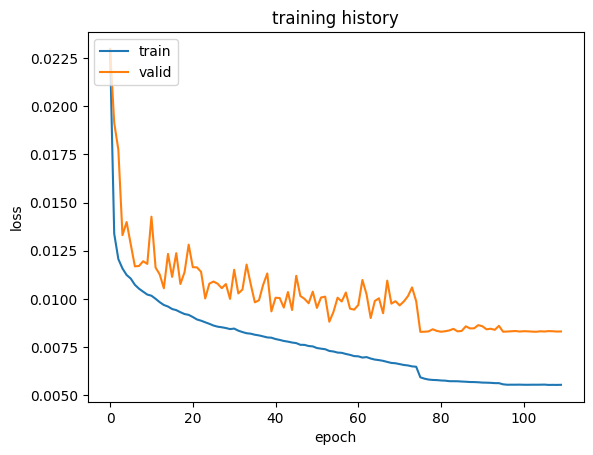

In [17]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss'])

plt.title('training history')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','valid'], loc='upper left')

plt.show()

In [18]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(9,4))
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim =' + str(latent_dim), fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

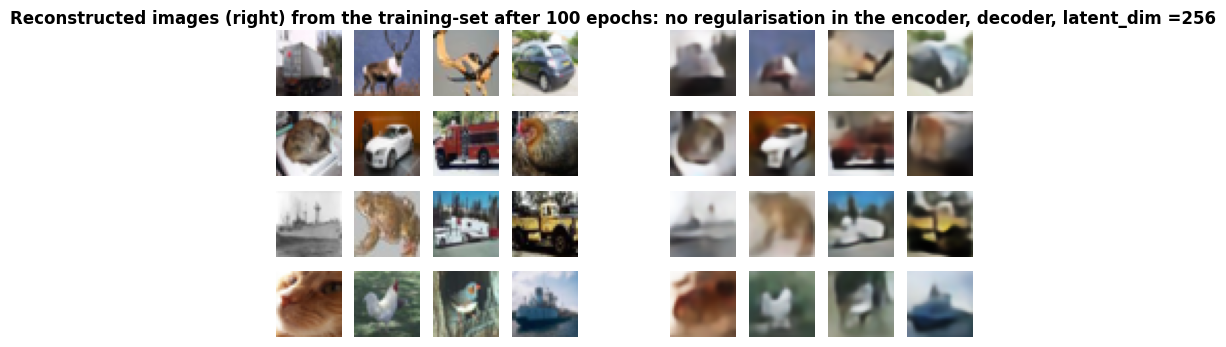

In [20]:
plot_reconstruction(img_train, 'training', 123, 100)

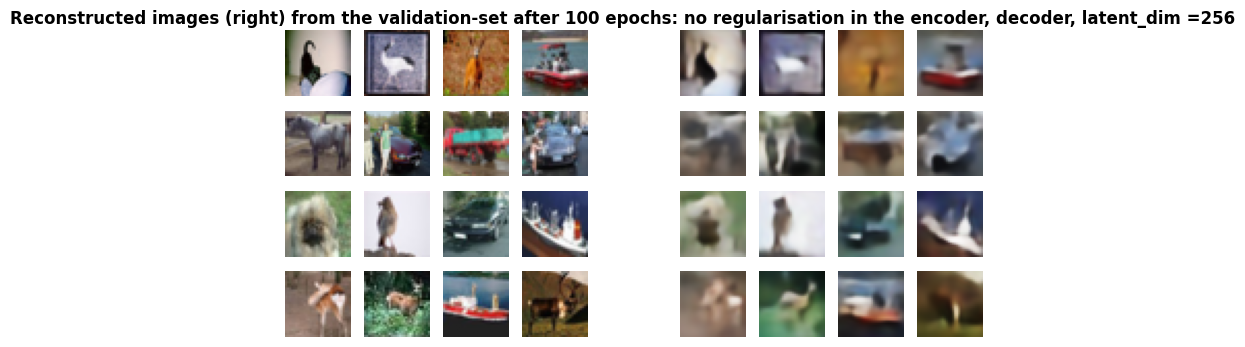

In [23]:
plot_reconstruction(img_valid, 'validation', 123, 100)

This is the best training set performance obtained, so the model has converged better, but it's not the best validation set performance, so it has done worse in terms of generalisation.

After a certain point, it's probably hitting vanishing gradients when it doesn't learn anymore, or reaches a local minima.

Naively I'd say it does not make sense to use bridge residual blocks for the one layer deep unit kernel convolutions (and the transverse), so we tried replacing them with plain conv or conv trans layers, but seems like they do make a difference for the better.